In [3]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install dicom

Note: you may need to restart the kernel to use updated packages.


In [3]:
conda install plotly

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\usman\anaconda3

  added / updated specs:
    - plotly


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |           py37_0         2.8 MB
    plotly-4.7.1               |             py_0         2.4 MB
    retrying-1.3.3             |           py37_2          16 KB
    ------------------------------------------------------------
                                           Total:         5.3 MB

The following NEW packages will be INSTALLED:

  plotly             pkgs/main/noarch::plotly-4.7.1-py_0
  retrying           pkgs/main/win-64::retrying-1.3.3-py37_2

The following packages will be UPDATED:

  conda                                        4.8.2-py37_0 --> 4.8.3-py37_0




conda-4.8.3          | 2.8 MB    |            |   0% 
conda-4.8.3          | 2.8 MB    |   

In [4]:
conda install scikit-image

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas 
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure, morphology, segmentation
import scipy.ndimage as ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True)

In [3]:
pip install dicom2nifti

Note: you may need to restart the kernel to use updated packages.


In [4]:
def load_scan(path):    
  #  files = os.listdir(folder)
    slices = [pydicom.dcmread(path + '/' + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if 'SliceLocation' in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
      slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])                   
    except:
      slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

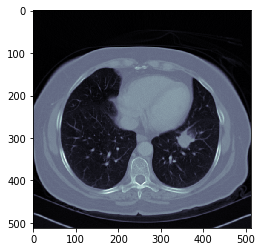

In [5]:
# set path and load files 
path = data_path = "lungs/"
patient_dicom = load_scan(path)
test_patient_images = get_pixels_hu(patient_dicom)
#sanity check
plt.imshow(test_patient_images[44], cmap=plt.cm.bone)

Internal Marker


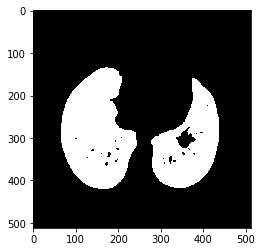

External Marker


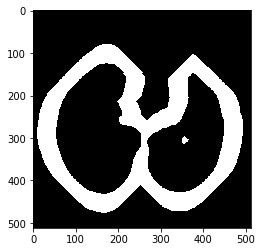

Watershed Marker


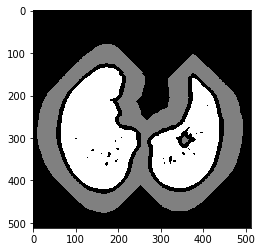

In [6]:
# Some of the starting Code is taken from ArnavJain, since it's more readable then my own
def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -300
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[44])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

Sobel Gradient


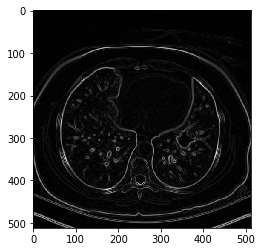

Watershed Image


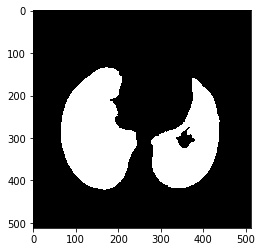

Outline after reinclusion


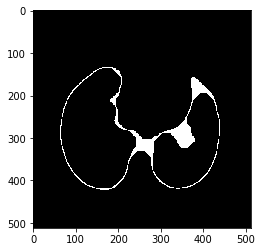

Lungfilter after closing


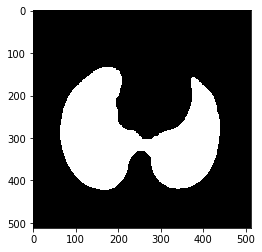

Segmented Lung


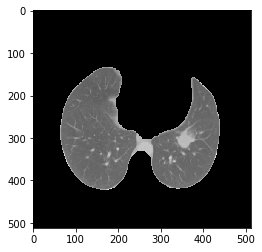

In [7]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(test_patient_images[44])

print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')

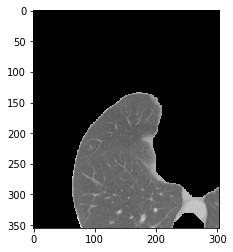

In [8]:
import matplotlib.pyplot as plt
cropped_image = test_segmented[0:355, 0:304]
plt.imshow(cropped_image, cmap='gray')
plt.show()

In [48]:
from tkinter import *
from PIL import ImageTk,Image
import tkinter

root = Tk()
root.title('Watershed Segmentation Veiwer')

#z = (test_patient_images[44] * 255).astype(np.uint8)
#z1 = (test_patient_internal * 255).astype(np.uint8)
#z2 = (test_patient_external * 255).astype(np.uint8)
#z3 = (test_patient_watershed * 255).astype(np.uint8)
#z4 = (test_sobel_gradient * 255).astype(np.uint8)
#z5 = (test_watershed * 255).astype(np.uint8)
#z6 = (test_outline * 255).astype(np.uint8)
#z7 = (test_lungfilter * 255).astype(np.uint8)
#z8 = (test_segmented * 255).astype(np.uint8)
#z9 = (cropped_image * 255).astype(np.uint8)

image = Image.fromarray(test_patient_images[44])
image1 = Image.fromarray(test_patient_internal)
image2 = Image.fromarray(test_patient_external)
image3 = Image.fromarray(test_patient_watershed)
image4 = Image.fromarray(test_sobel_gradient)
image5 = Image.fromarray(test_watershed)
image6 = Image.fromarray(test_outline)
image7 = Image.fromarray(test_lungfilter)
image8 = Image.fromarray(test_segmented)
image9 = Image.fromarray(cropped_image)

img1 = ImageTk.PhotoImage(image)
img2 = ImageTk.PhotoImage(image1)
img3 = ImageTk.PhotoImage(image2)
img4 = ImageTk.PhotoImage(image3)
img5 = ImageTk.PhotoImage(image4)
img6 = ImageTk.PhotoImage(image5)
img7 = ImageTk.PhotoImage(image6)
img8 = ImageTk.PhotoImage(image7)
img9 = ImageTk.PhotoImage(image8)
img10 = ImageTk.PhotoImage(image9)

image_list = [img1,img2,img3,img4,img5,img6,img7,img8,img9,img10] 
my_label =Label(image = img1)
my_label.grid(row=0, column=0,columnspan=3)

def forward(image_number):
    global my_label
    global button_forward
    global button_back 
    my_label.grid_forget()
    my_label = Label(image=image_list[image_number-1])
    button_forward = Button(root,text = ">>", command = lambda:forward(image_number+1))
    button_back = Button(root,text = "<<", command = lambda:back(image_number-1))
    
    if image_number ==10:
        button_forward = Button(root,text=">>", state=DISABLED)

    my_label.grid(row=0, column=0,columnspan=3)
    button_back.grid(row=1,column=0)
    button_forward.grid(row=1,column=2)

def back(image_number):
    global my_label
    global button_forward
    global button_back  
    
    my_label.grid_forget()
    my_label = Label(image=image_list[image_number-1])
    button_forward = Button(root,text = ">>", command = lambda:forward(image_number+1))
    button_back = Button(root,text = "<<", command = lambda:back(image_number-1))
    
    if image_number ==1:
        button_back = Button(root,text="<<", state=DISABLED)
    
    my_label.grid(row=0, column=0,columnspan=3)
    button_back.grid(row=1,column=0)
    button_forward.grid(row=1,column=2)

w = Label(root, text="1.Test_patient_images slice 44 ")
w1 = Label(root, text="2.Test_patient_internal")
w2 = Label(root, text="3.Test_patient_external")
w3 = Label(root, text="4.Test_patient_watershed")
w4 = Label(root, text="5.Test_sobel_gradient")
w5 = Label(root, text="6.Test_watershed")
w6 = Label(root, text="7.Test_outline")
w7 = Label(root, text="8.Test_lungfilter")
w8 = Label(root, text="9.Test_segmented")
w9 = Label(root, text="10.Cropped_image")

button_back = Button(root,text = "<<", command = lambda:back, state=DISABLED)
button_forward = Button(root,text = ">>", command = lambda:forward(2))
#button_exit = Button(root,text = "Exit App", command = root.quit)

button_back.grid(row=1,column=0)
#button_exit.grid(row=1,column=1)
button_forward.grid(row=1,column=2)
w.grid(row=2,column=0)
w1.grid(row=2,column=1)
w2.grid(row=2,column=2)
w3.grid(row=3,column=0)
w4.grid(row=3,column=1)
w5.grid(row=3,column=2)
w6.grid(row=4,column=0)
w7.grid(row=4,column=1)
w8.grid(row=4,column=2)
w9.grid(row=5,column=1)

root.mainloop()